In [13]:
!pip install category_encoders
!pip install texthero

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 238 kB 9.9 MB/s 
     |████████████████████████████████| 1.4 MB 7.6 MB/s 
     |████████████████████████████████| 10.4 MB 5.8 MB/s 
     |████████████████████████████████| 366 kB 3.4 MB/s 
     |████████████████████████████████| 24.2 MB 5.4 MB/s 
     |████████████████████████████████| 6.8 MB 11.1 MB/s 
     |████████████████████████████████| 82 kB 2.4 MB/s 
     |████████████████████████████████| 723 kB 15.3 MB/s 
     |████████████████████████████████| 293 kB 2.6 MB/s 
     |████████████████████████████████| 284 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 9.9 MB/s 
     |████████████████████████████████| 117 kB 17.9 MB/s 
  Cr

In [84]:
import pandas as pd
import pathlib
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import texthero as hero
from texthero import preprocessing

from sklearn import metrics
from sklearn.model_selection import GroupKFold, KFold

import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_squared_log_error


In [105]:
DATA_DIR = pathlib.Path('/home/knikaido/work/atma8/data/')
OUTPUT_DIR = './sub06/'
train_csv_path = DATA_DIR / 'train.csv'
test_csv_path = DATA_DIR / 'test.csv'

In [106]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [107]:
oof = pd.read_csv('./sub17/oof17.csv')
train_df['oof'] = np.expm1(oof['Global_Sales'])

In [108]:
true_log = np.log1p(train_df['Global_Sales'])
pred_log = np.log1p(train_df['oof'])

In [109]:
score = (true_log - pred_log) ** 2
np.mean(score)

0.8259983056829912

In [110]:
train_df['score'] = score

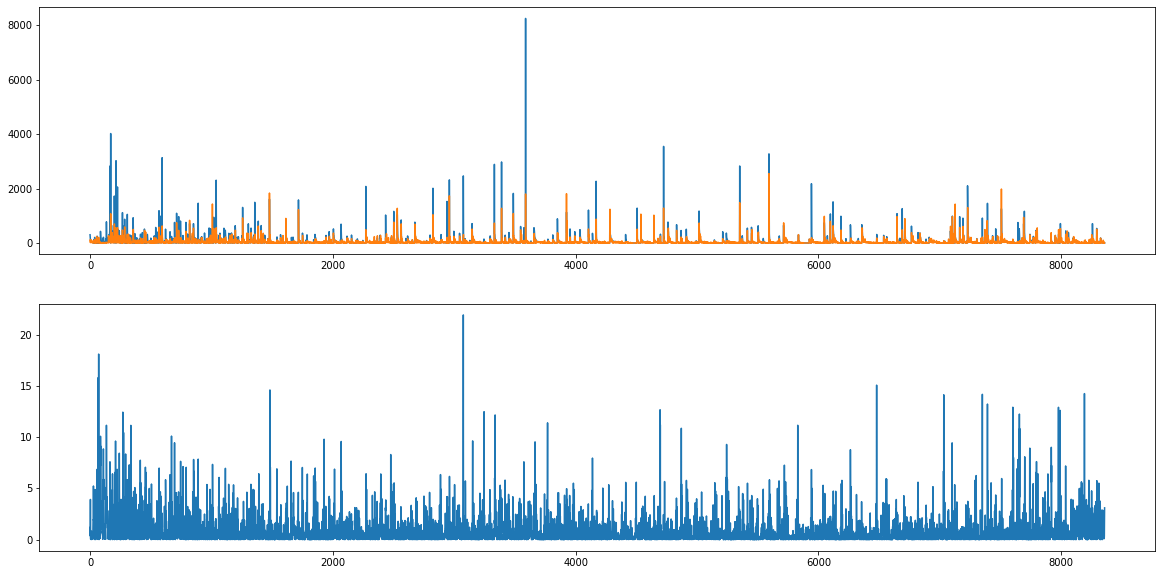

In [111]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(train_df['Global_Sales'])
ax[0].plot(train_df['oof'])
ax[1].plot(train_df['score'])

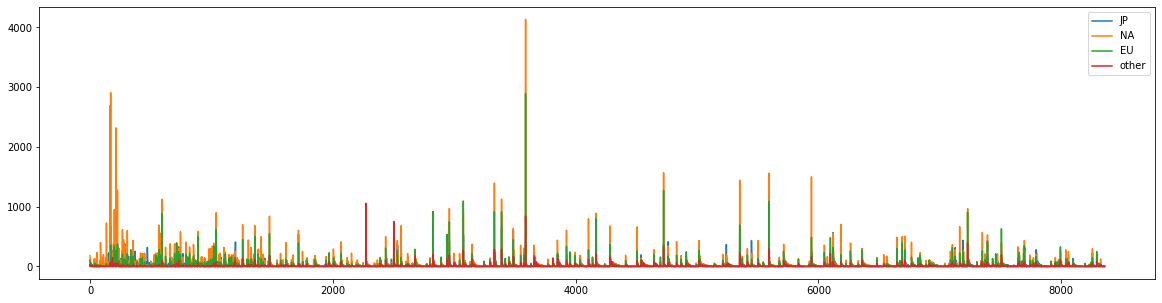

In [112]:
fig = plt.figure(figsize=(20, 5))
plt.plot(train_df['JP_Sales'], label='JP')
plt.plot(train_df['NA_Sales'], label='NA')
plt.plot(train_df['EU_Sales'], label='EU')
plt.plot(train_df['Other_Sales'], label='other')
plt.legend()

In [113]:
train_df.iloc[train_df['score'].values.argsort()[::-1][0]]

Name               Nintendogs
Platform                   DS
Year_of_Release          2005
Genre              Simulation
Publisher            Nintendo
NA_Sales                  905
EU_Sales                 1095
JP_Sales                  193
Other_Sales               274
Global_Sales             2467
Critic_Score              NaN
Critic_Count              NaN
User_Score                NaN
User_Count                NaN
Developer                 NaN
Rating                    NaN
oof                   21.7397
score                 21.9685
Name: 3075, dtype: object

In [114]:
df_nan = train_df.isnull()

In [115]:
counts = []
for i in range(len(df_nan)):
    if(df_nan['Critic_Score'][i]==True):
        if(df_nan['Critic_Count'][i]==True):
            if(df_nan['User_Score'][i]==True):
                if(df_nan['User_Count'][i]==True):
                    if(df_nan['Developer'][i]==True):
                        if(df_nan['Rating'][i]==True):
                            counts.append(i)
len(counts)
                    


3479

In [116]:
df_nan_train = train_df.iloc[counts]

In [117]:
np.mean(train_df['score'])

0.8259983056829912

In [118]:
np.mean(df_nan_train['score'])

1.048035247810841

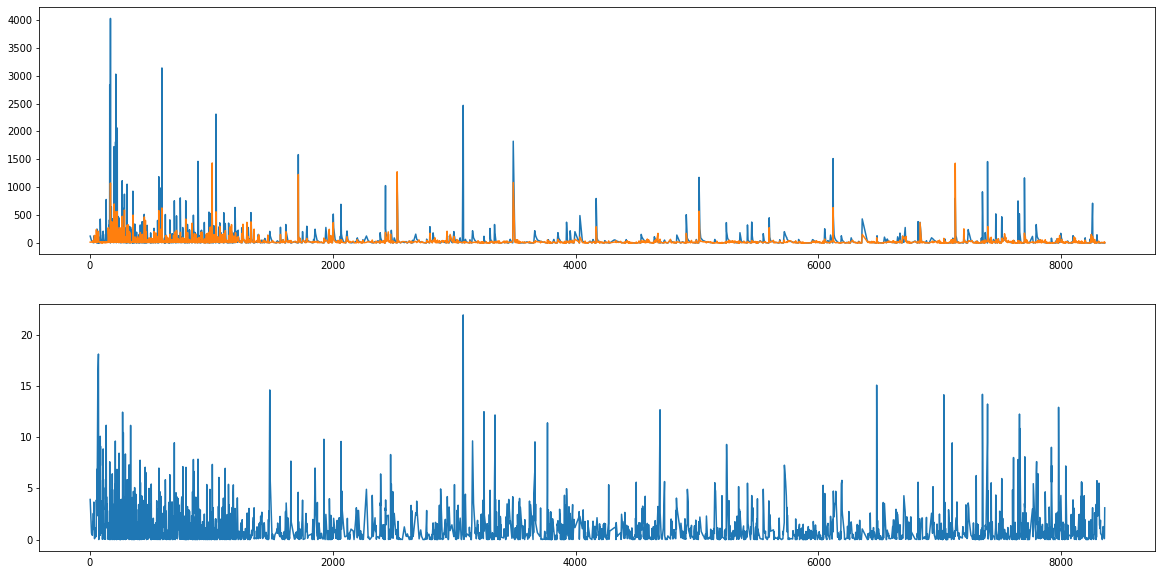

In [119]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(df_nan_train['Global_Sales'])
ax[0].plot(df_nan_train['oof'])
ax[1].plot(df_nan_train['score'])

In [120]:
np.mean(df_nan_train['score'])

1.048035247810841

In [121]:
oof_custom = []
m_ = np.mean(train_df['oof'])
for oof in  train_df['oof']:
    if(oof > 500):
        oof_custom.append(oof*1.5)
    else:
        oof_custom.append(oof)

In [122]:
pred_log = np.log1p(oof_custom)

In [123]:
score = (true_log - pred_log) ** 2

In [124]:
np.mean(score)

0.8259457854520617

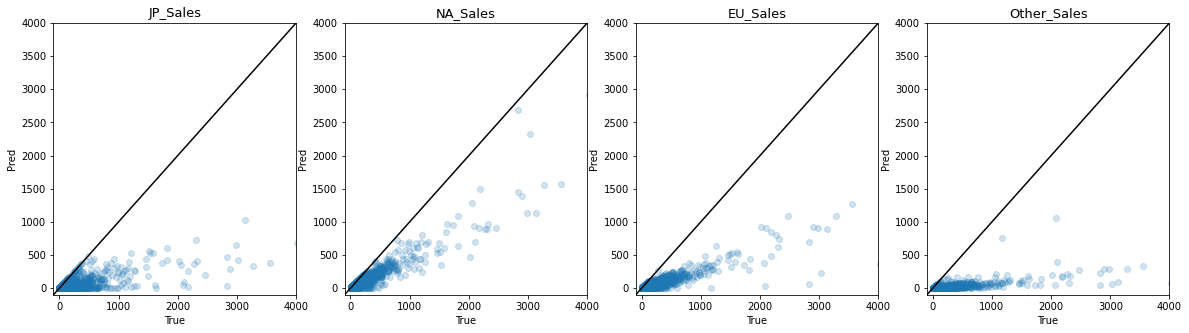

In [125]:
sales_list = ['JP_Sales', 'NA_Sales', 'EU_Sales', 'Other_Sales']
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i in range(len(sales_list)): 
    ax[i].plot([-200, 8000], [-200, 8000], color='black')
    ax[i].scatter(train_df['Global_Sales'], train_df[sales_list[i]], alpha=0.2)
    ax[i].set_xlim(-100, 4000)
    ax[i].set_ylim(-100, 4000)
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')
    ax[i].set_title(sales_list[i], fontsize=13)

<AxesSubplot:xlabel='Global_Sales'>

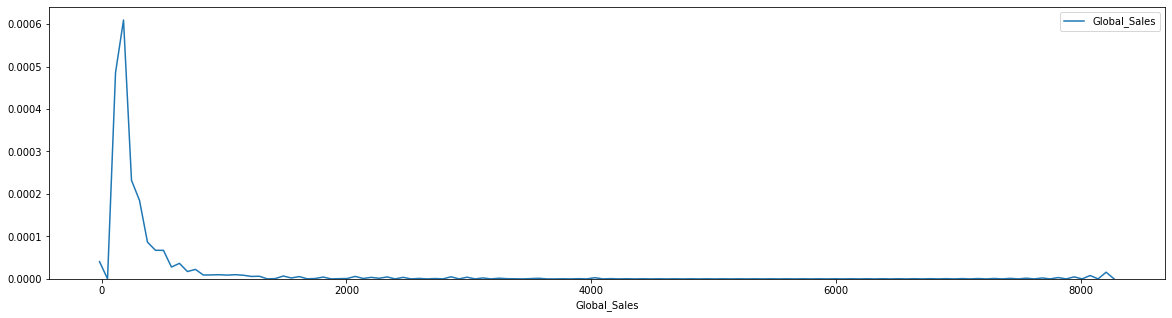

In [126]:
fig = plt.figure(figsize=(20, 5))
sns.distplot(train_df['Global_Sales'], 
             hist=False, label='Global_Sales')

In [127]:
train_df.iloc[np.argmax(train_df['Global_Sales'])]

Name               Wii Sports
Platform                  Wii
Year_of_Release          2006
Genre                  Sports
Publisher            Nintendo
NA_Sales                 4136
EU_Sales                 2896
JP_Sales                  377
Other_Sales               844
Global_Sales             8253
Critic_Score               76
Critic_Count               51
User_Score                  8
User_Count                322
Developer            Nintendo
Rating                      E
oof                   1802.47
score                  2.3134
Name: 3588, dtype: object

In [128]:
train_genre_df = train_df.groupby('Genre').mean()

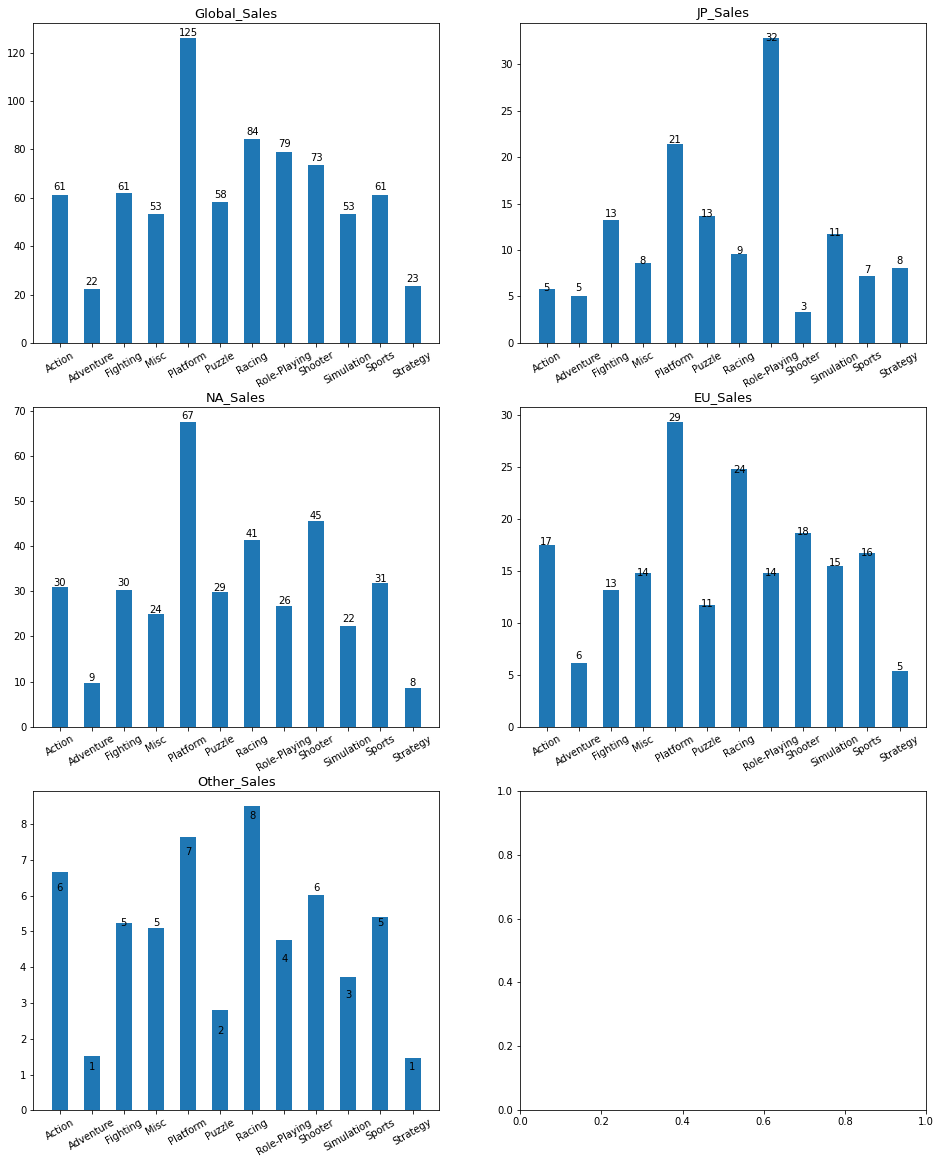

In [71]:
fig, ax = plt.subplots(3, 2, figsize=(16, 20))
sales_list = ['Global_Sales', 'JP_Sales', 'NA_Sales', 'EU_Sales', 'Other_Sales']
labels = list(train_genre_df.index)
x = np.arange(len(labels))
width = 0.5

for i in range(len(sales_list)): 
    sales = train_genre_df[sales_list[i]]
    yoko = int(i%2)
    tate = int(i/2)

    rect = ax[tate][yoko].bar(x, sales, width)
    ax[tate][yoko].set_xticks(x)
    ax[tate][yoko].set_xticklabels(labels, rotation=30)
    ax[tate][yoko].set_title(sales_list[i], fontsize=13)

    def autolabel(rects):
        for rect in rects:
            height = int(rect.get_height())
            ax[tate][yoko].annotate('{}'.format(height),
                       xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')
    autolabel(rect)      


In [74]:
train_rate_df = train_df.groupby('Rating').mean()

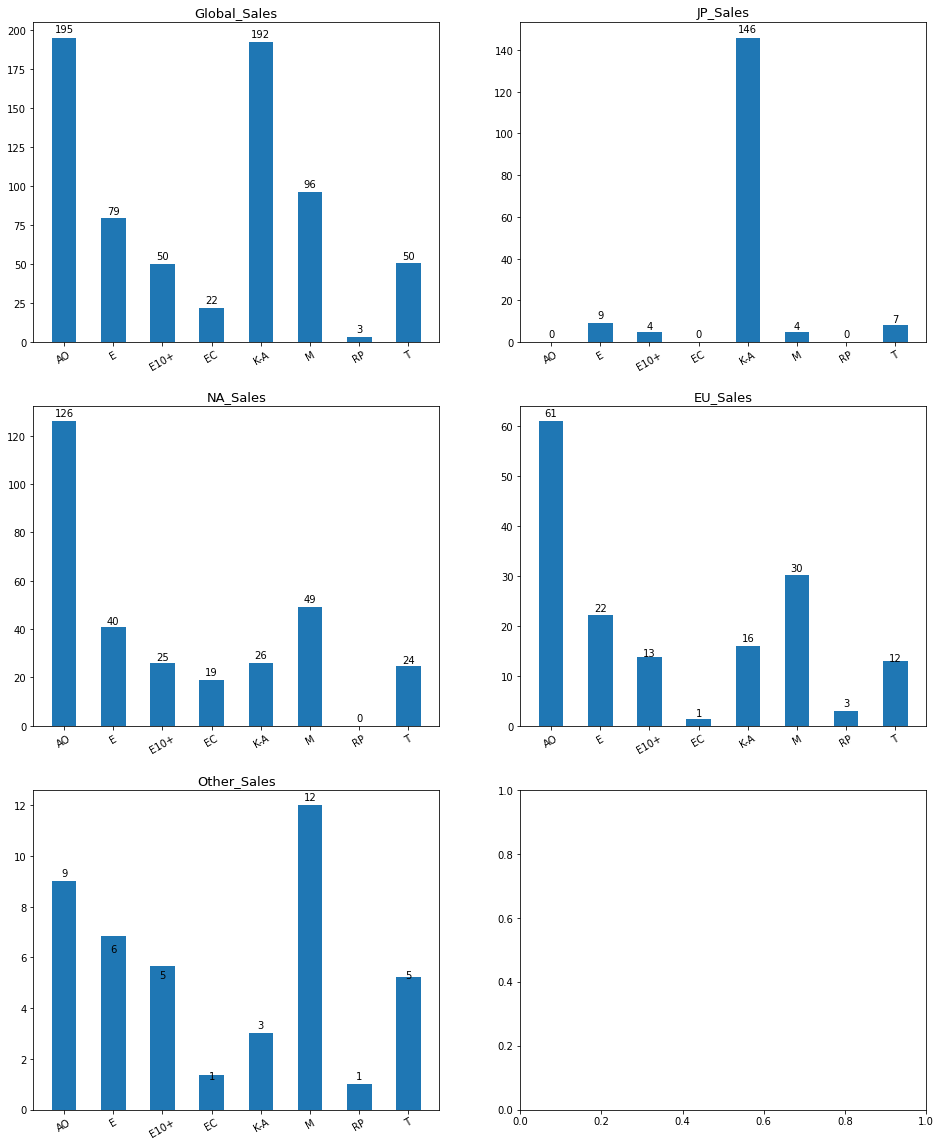

In [76]:
fig, ax = plt.subplots(3, 2, figsize=(16, 20))
sales_list = ['Global_Sales', 'JP_Sales', 'NA_Sales', 'EU_Sales', 'Other_Sales']
labels = list(train_rate_df.index)
x = np.arange(len(labels))
width = 0.5

for i in range(len(sales_list)): 
    sales = train_rate_df[sales_list[i]]
    yoko = int(i%2)
    tate = int(i/2)

    rect = ax[tate][yoko].bar(x, sales, width)
    ax[tate][yoko].set_xticks(x)
    ax[tate][yoko].set_xticklabels(labels, rotation=30)
    ax[tate][yoko].set_title(sales_list[i], fontsize=13)

    def autolabel(rects):
        for rect in rects:
            height = int(rect.get_height())
            ax[tate][yoko].annotate('{}'.format(height),
                       xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')
    autolabel(rect)      


In [4]:
train_column = train_df.columns

In [5]:
X_column = []
for s in train_column:
    if not'Sales' in s:
        X_column.append(s)

In [6]:
train_df_drop = train_df[X_column]

In [7]:
# User_Scoreの変換
def make_user_score(df):
    d = df['User_Score'].copy()
    d[d == 'tbd'] = 'nan'
    df.loc[:,'User_Score'] = d
    
    return df

In [8]:
train_df_drop = make_user_score(train_df_drop)
test_df = make_user_score(test_df)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [9]:
# Ratingの変換

In [10]:
def encode_label(train, test):
    cate_col = ['Rating', 'Platform', 'Genre']
    oe = ce.OrdinalEncoder(cols=cate_col, drop_invariant=True, handle_missing='return_nan')
    train.loc[:,cate_col] = oe.fit_transform(train[cate_col])
    test.loc[:,cate_col] = oe.transform(test[cate_col])
    return train, test

In [11]:
train_df_drop, test_df = encode_label(train_df_drop, test_df)

/home/user/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1717: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                  ]

In [13]:
def translate_name(df):
    n_pca = hero.pca(hero.tfidf(hero.clean(df['Name'], pipeline=custom_pipeline)))
    n_pca_l = []
    for i in range(len(n_pca)):
        n_pca_l.append(n_pca.values[i])
    n_pca_np = np.array(n_pca_l)
    df['Name_0'] = n_pca_np[:, 0]
    df['Name_1'] = n_pca_np[:, 1]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Developer'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Developer_0'] = n_pca_np[:, 0]
#     df['Developer_1'] = n_pca_np[:, 1]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Publisher'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Publisher_0'] = n_pca_np[:, 0]
#     df['Publisher_1'] = n_pca_np[:, 1]
    
    return df

In [14]:
train_df_drop = translate_name(train_df_drop)
test_df = translate_name(test_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [15]:
drop_c = ['Name', 'Publisher', 'Developer']
train_df_drop.drop(drop_c, axis=1, inplace=True)
test_df.drop(drop_c, axis=1, inplace=True)
train_df_drop

,Platform,Year_of_Release,Genre,Critic_Score,Critic_Count,User_Score,User_Count,Rating,Name_0,Name_1,Developer_0,Developer_1,Publisher_0,Publisher_1
0,1.0,NaN,1.0,74.0,17.0,7.9,22.0,1.0,0.242318,-0.148236,-0.046724,-0.045789,0.222113,-0.060063
1,1.0,NaN,1.0,78.0,22.0,6.6,28.0,1.0,0.143301,-0.083303,-0.046724,-0.045789,-0.005570,0.004847
2,2.0,NaN,1.0,73.0,5.0,7.4,10.0,1.0,0.242318,-0.148236,-0.046724,-0.045789,0.222113,-0.060063
3,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,-0.043794,-0.003331,-0.018656,-0.016228,-0.009927,0.008765
4,1.0,NaN,1.0,76.0,8.0,7.8,13.0,1.0,-0.005713,-0.092999,-0.046724,-0.045789,0.222113,-0.060063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,9.0,2016.0,12.0,78.0,57.0,8,569.0,NaN,-0.039636,0.000085,-0.025454,-0.022860,0.011136,0.001527
8355,9.0,2016.0,12.0,NaN,NaN,NaN,NaN,NaN,-0.025877,0.012678,-0.018656,-0.016228,-0.004980,0.004418
8356,14.0,2017.0,1.0,NaN,NaN,NaN,NaN,NaN,-0.038572,-0.000808,-0.018656,-0.016228,-0.005982,0.005204
8357,30.0,2017.0,8.0,NaN,NaN,NaN,NaN,NaN,-0.029606,-0.058282,-0.018656,-0.016228,-0.042429,0.041818


In [16]:
train_df_drop = train_df_drop.astype('float64')
test_df = test_df.astype('float64')

In [17]:
X = train_df_drop
y = train_df['Global_Sales'].astype('float64')
groups = train_df['Publisher']

In [18]:


# kfoldの分割数
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=0)
# kf = GroupKFold(n_splits=k)

lgbm_params = {'objective': 'regression',
              "metric":"rmse",
              "learning_rate": 0.05,
               'colsample_bytree': 0.8}

rmsle_train_list = []
rmsle_eval_list = []

pred_test_np = np.zeros([k, len(test_df)])
oof_pred = np.zeros_like(y, dtype=np.float)

# kfoldで分割
for i, (train_index, test_index) in enumerate(kf.split(X, y)):

    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)

    # データセットを生成する
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test)

    # 学習
    model = lgb.train(lgbm_params,
                        lgb_train,
                        valid_sets=[lgb_eval, lgb_train],
                        num_boost_round=10000,
                        early_stopping_rounds=1000,
                        verbose_eval=200)

    predict_train = model.predict(X_train, num_iteration=model.best_iteration)
    predict_eval = model.predict(X_test, num_iteration=model.best_iteration)
    oof_pred[test_index] = predict_eval
    
    rmsle_train = np.sqrt(mean_squared_error(y_train, predict_train))
    rmsle_eval = np.sqrt(mean_squared_error(y_test, predict_eval))
    print(f'RMSLE_train: {rmsle_train}, RMSLE_eval: {rmsle_eval}')
    rmsle_train_list.append(rmsle_train)
    rmsle_eval_list.append(rmsle_eval)
    
    pred_test_np[i] = model.predict(test_df, num_iteration=model.best_iteration)
    
print(f'RMSLE_train_mean: {np.mean(rmsle_train_list)}, RMSLE_eval_mean: {np.mean(rmsle_eval_list)}')

    # predict_probaが0.5以上なら1とする
#     predict = [0 if i < 0.5 else 1 for i in predict_proba]

#     auc, precision, recall = get_evaluate(y_test, predict)

#     print('AUC:{}, precision:{}, recall:{}'.format(auc, precision, recall))

#     auc_list.append(auc)
#     precision_list.append(precision)
#     recall_list.append(recall)

# # kfoldの平均値を取得
# print('Kfold平均 AUC:{}, precision:{}, recall:{}'.format(np.mean(auc_list), 
#                                                          np.mean(precision_list), 
#                                                          np.mean(recall_list)))

Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 0.733133	valid_0's rmse: 0.866366
[400]	training's rmse: 0.620232	valid_0's rmse: 0.855007
[600]	training's rmse: 0.544816	valid_0's rmse: 0.852757
[800]	training's rmse: 0.487084	valid_0's rmse: 0.854428
[1000]	training's rmse: 0.440569	valid_0's rmse: 0.858394
[1200]	training's rmse: 0.401445	valid_0's rmse: 0.859679
[1400]	training's rmse: 0.370155	valid_0's rmse: 0.861518
Early stopping, best iteration is:
[574]	training's rmse: 0.553088	valid_0's rmse: 0.852478
RMSLE_train: 0.5530882516521882, RMSLE_eval: 0.8524778987581187
Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 0.734217	valid_0's rmse: 0.898661
[400]	training's rmse: 0.629153	valid_0's rmse: 0.876825
[600]	training's rmse: 0.553696	valid_0's rmse: 0.86571
[800]	training's rmse: 0.49413	valid_0's rmse: 0.865728
[1000]	training's rmse: 0.447924	valid_0's rmse: 0.866045
[1200]	training's rmse: 0.406417

In [19]:
print(np.sqrt(mean_squared_error(np.log1p(y), oof_pred)))

0.8619597766975781


In [20]:
oof_df = pd.DataFrame(oof_pred, columns=['Global_Sales'])
oof_df.to_csv(OUTPUT_DIR + "oof05.csv", index = False)

In [21]:
pred_test_mean = np.mean(pred_test_np, axis=0)
pred_test_exp = np.expm1(pred_test_mean)

In [22]:
sub = pd.read_csv(DATA_DIR / 'atmaCup8_sample-submission.csv')
sub['Global_Sales'] = pred_test_exp
sub.to_csv(OUTPUT_DIR + "sub05.csv", index = False)

In [23]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    model = models
#     for i, model in enumerate(models):
    _df = pd.DataFrame()
    _df['feature_importance'] = model.feature_importance(importance_type='gain')
    _df['column'] = feat_train_df.columns
    _df['fold'] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

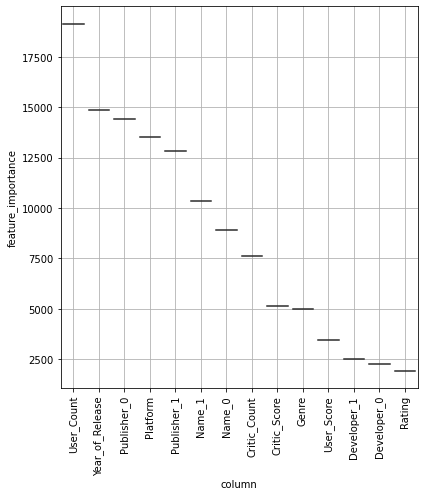

In [24]:
fig, ax = visualize_importance(model, X)


In [25]:
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=train_df_drop.columns, columns=['importance'])
importance.sort_values(['importance'])

,importance
Rating,1923.628176
Developer_0,2262.207175
Developer_1,2521.593219
User_Score,3441.732117
Genre,4986.717704
Critic_Score,5141.556932
Critic_Count,7634.363927
Name_0,8909.336788
Name_1,10338.221252
Publisher_1,12838.359179
